In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost

import os





Value = Monthly Average Temperature
Anomaly = Temperature anomaly = How much warmer/colder the month was compared to the long-term normal.

| Anomaly | Meaning                                   |
| ------- | ----------------------------------------- |
| `0.0`   | Exactly normal temperature for that month |
| `+0.6`  | 0.6°F (or °C) warmer than usual           |
| `-2.0`  | 2°F colder than usual                     |
| `-1.4`  | 1.4°F colder than average                 |


In [33]:
df = pd.read_csv("Consumption_merged_dataset.csv")
df


,Unnamed: 0,State,Year,Month,Residential_MkWh,Industrial_MkWh,Commercial_MkWh,Value,Anomaly
0,0,AL,2000,1,2566699.00,2912590.00,1444098.00,63.9,0.0
1,1,AL,2000,2,2318484.00,2676927.00,1366694.00,63.9,0.0
2,2,AL,2000,3,1694681.00,2785039.00,1375682.00,64.5,0.6
3,3,AL,2000,4,1631559.00,2891342.00,1351320.00,63.9,0.0
4,4,AL,2000,5,2104031.00,3005015.00,1648653.00,64.2,0.3
...,...,...,...,...,...,...,...,...,...
13819,13819,WY,2023,8,214644.24,734192.99,448928.93,40.7,-1.8
13820,13820,WY,2023,9,178807.44,712993.73,429896.37,40.5,-2.0
13821,13821,WY,2023,10,196879.96,747627.37,442331.38,40.4,-2.1
13822,13822,WY,2023,11,238783.12,754695.33,444573.06,41.1,-1.4


## Data Preparation and Preprocessing


In [34]:
# Import required libraries for predictive analysis
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.base import BaseEstimator, RegressorMixin, clone
from xgboost import XGBRegressor
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")


✓ All libraries imported successfully


In [35]:
# Step 1: Prepare monthly aggregated time series data
# Aggregate total consumption by month across all states

# Create Date column from Year and Month
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(day=1))

# Calculate Total Consumption (sum of Residential, Commercial, Industrial)
df['Total_Consumption_GWh'] = (
    df['Residential_MkWh'].fillna(0) +
    df['Industrial_MkWh'].fillna(0) +
    df['Commercial_MkWh'].fillna(0)
)

# Aggregate monthly totals across all states
monthly_ts = df.groupby('Date')['Total_Consumption_GWh'].sum().reset_index()
monthly_ts = monthly_ts.set_index('Date').sort_index()
monthly_ts = monthly_ts[['Total_Consumption_GWh']]

print(f"Time series shape: {monthly_ts.shape}")
print(f"Date range: {monthly_ts.index.min()} to {monthly_ts.index.max()}")
print(f"\nFirst few rows:")
print(monthly_ts.head())
print(f"\nLast few rows:")
print(monthly_ts.tail())
print(f"\nBasic statistics:")
print(monthly_ts.describe())


Time series shape: (288, 1)
Date range: 2000-01-01 00:00:00 to 2023-12-01 00:00:00

First few rows:
            Total_Consumption_GWh
Date                             
2000-01-01            277009165.0
2000-02-01            261568970.0
2000-03-01            251831186.0
2000-04-01            238946027.0
2000-05-01            258065001.0

Last few rows:
            Total_Consumption_GWh
Date                             
2023-08-01           3.896472e+08
2023-09-01           3.436574e+08
2023-10-01           3.054782e+08
2023-11-01           2.916907e+08
2023-12-01           3.100101e+08

Basic statistics:
       Total_Consumption_GWh
count           2.880000e+02
mean            3.038124e+08
std             3.224995e+07
min             2.389460e+08
25%             2.809132e+08
50%             2.978025e+08
75%             3.234143e+08
max             3.896472e+08


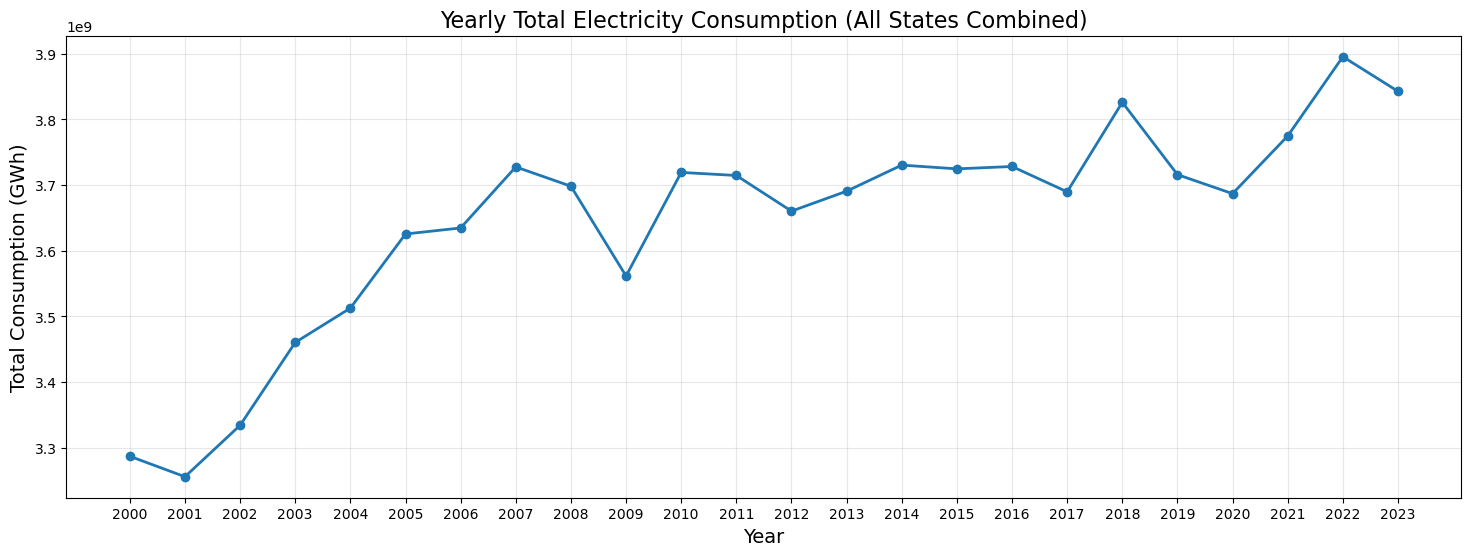

In [36]:
import matplotlib.pyplot as plt

# Compute yearly total consumption for all states combined
yearly_consumption = (
    df.groupby('Year')['Total_Consumption_GWh']
      .sum()
      .reset_index()
)

plt.figure(figsize=(18,6))
plt.plot(
    yearly_consumption['Year'], 
    yearly_consumption['Total_Consumption_GWh'], 
    marker='o', linewidth=2
)

plt.title("Yearly Total Electricity Consumption (All States Combined)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Total Consumption (GWh)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(range(2000, 2024))  # ensures years 2000–2023 show cleanly
plt.show()


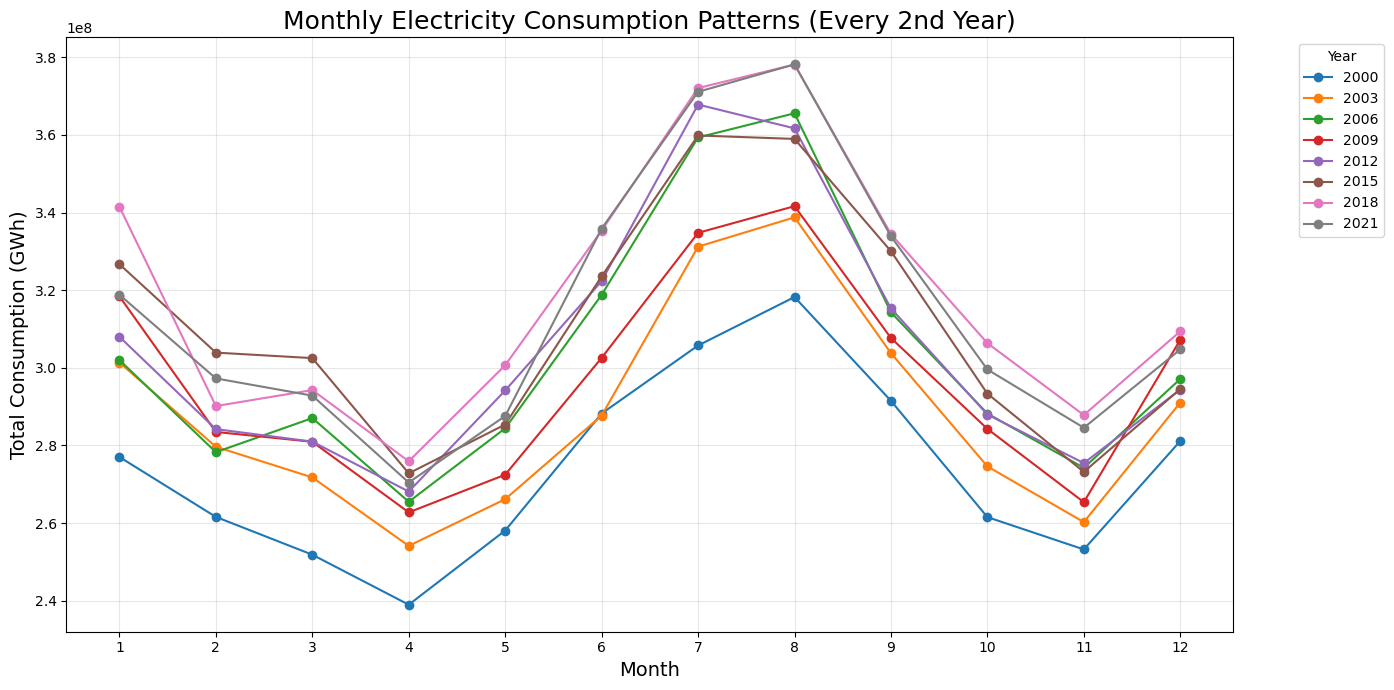

In [37]:
import matplotlib.pyplot as plt

# Aggregate monthly consumption for each year
monthly_by_year = (
    df.groupby(['Year', 'Month'])['Total_Consumption_GWh']
      .sum()
      .reset_index()
)

# Select every 2nd year (even years)
years_to_plot = list(range(2000, 2024, 3))

plt.figure(figsize=(14,7))

for year in years_to_plot:
    subset = monthly_by_year[monthly_by_year['Year'] == year]
    plt.plot(
        subset['Month'], 
        subset['Total_Consumption_GWh'], 
        marker='o', 
        label=str(year)
    )

plt.title("Monthly Electricity Consumption Patterns (Every 2nd Year)", fontsize=18)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Total Consumption (GWh)", fontsize=14)
plt.xticks(range(1,13))  # Months 1 to 12
plt.grid(True, alpha=0.3)
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')  # move legend outside
plt.tight_layout()
plt.show()


## Feature Engineering


In [38]:
def create_time_series_features(df, target_col='Total_Consumption_GWh'):
    """
    Create comprehensive time series features:
    - Time features: year, month, month_sin, month_cos
    - Lags: lag_1 to lag_12
    - Rolling features: rolling means and stds
    - Trend: numeric time index
    """
    df = df.copy()
    
    # Ensure index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("Index must be DatetimeIndex")
    
    # Time features
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # Trend: months since start
    df['time_index'] = np.arange(len(df))
    
    # Lags (1 to 12 months) - CRITICAL: use .shift() to avoid leakage
    for lag in range(1, 13):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    
    # Rolling features (using past values only)
    df['roll_mean_3'] = df[target_col].shift(1).rolling(window=3, min_periods=1).mean()
    df['roll_mean_6'] = df[target_col].shift(1).rolling(window=6, min_periods=1).mean()
    df['roll_mean_12'] = df[target_col].shift(1).rolling(window=12, min_periods=1).mean()
    
    df['roll_std_3'] = df[target_col].shift(1).rolling(window=3, min_periods=1).std()
    df['roll_std_6'] = df[target_col].shift(1).rolling(window=6, min_periods=1).std()
    df['roll_std_12'] = df[target_col].shift(1).rolling(window=12, min_periods=1).std()
    
    # Year-over-year change (lag 12)
    df['yoy_change'] = df[target_col] - df[target_col].shift(12)
    df['yoy_pct_change'] = (df[target_col] / df[target_col].shift(12) - 1) * 100
    
    # Month-over-month change
    df['mom_change'] = df[target_col] - df[target_col].shift(1)
    df['mom_pct_change'] = (df[target_col] / df[target_col].shift(1) - 1) * 100
    
    return df

# Create features
featured_df = create_time_series_features(monthly_ts[['Total_Consumption_GWh']])

# Drop rows with NaN (from lags and rolling features)
featured_df = featured_df.dropna()

print(f"Shape after feature engineering: {featured_df.shape}")
print(f"\nFeature columns:")
print([col for col in featured_df.columns if col != 'Total_Consumption_GWh'])
print(f"\nFirst few rows:")
print(featured_df.head())


Shape after feature engineering: (276, 28)

Feature columns:
['year', 'month', 'month_sin', 'month_cos', 'time_index', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'roll_mean_3', 'roll_mean_6', 'roll_mean_12', 'roll_std_3', 'roll_std_6', 'roll_std_12', 'yoy_change', 'yoy_pct_change', 'mom_change', 'mom_pct_change']

First few rows:
            Total_Consumption_GWh  year  month  month_sin     month_cos  \
Date                                                                      
2001-01-01            299157983.0  2001      1   0.500000  8.660254e-01   
2001-02-01            261616808.0  2001      2   0.866025  5.000000e-01   
2001-03-01            258275174.0  2001      3   1.000000  6.123234e-17   
2001-04-01            243792613.0  2001      4   0.866025 -5.000000e-01   
2001-05-01            253291888.0  2001      5   0.500000 -8.660254e-01   

            time_index        lag_1        lag_2        lag_3        lag_4

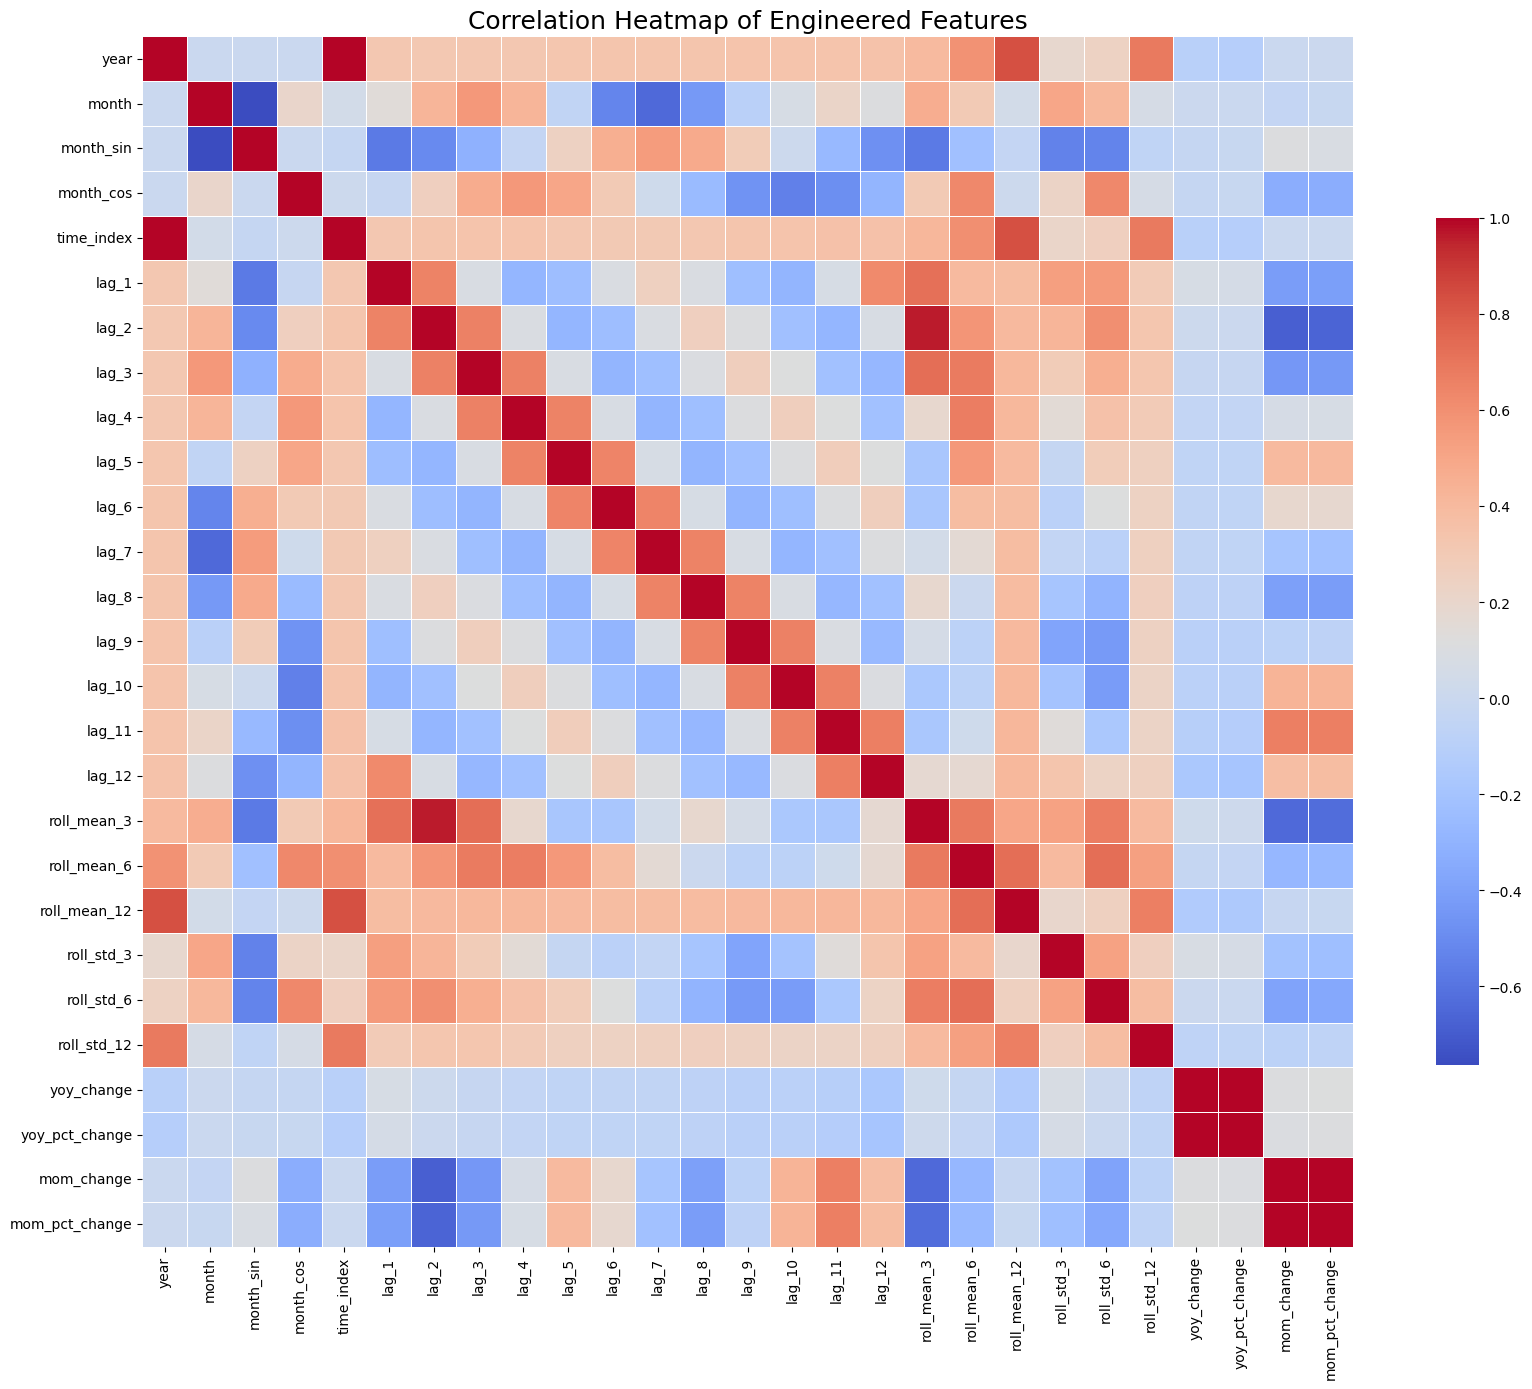

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Remove target column if present
corr_df = featured_df.drop(columns=['Total_Consumption_GWh'])

plt.figure(figsize=(18, 14))

sns.heatmap(
    corr_df.corr(),
    cmap="coolwarm",
    annot=False,
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.7}
)

plt.title("Correlation Heatmap of Engineered Features", fontsize=18)
plt.tight_layout()
plt.show()


Training set: 2001-01-01 00:00:00 to 2019-04-01 00:00:00 (220 months)
Test set: 2019-05-01 00:00:00 to 2023-12-01 00:00:00 (56 months)

Number of features: 27


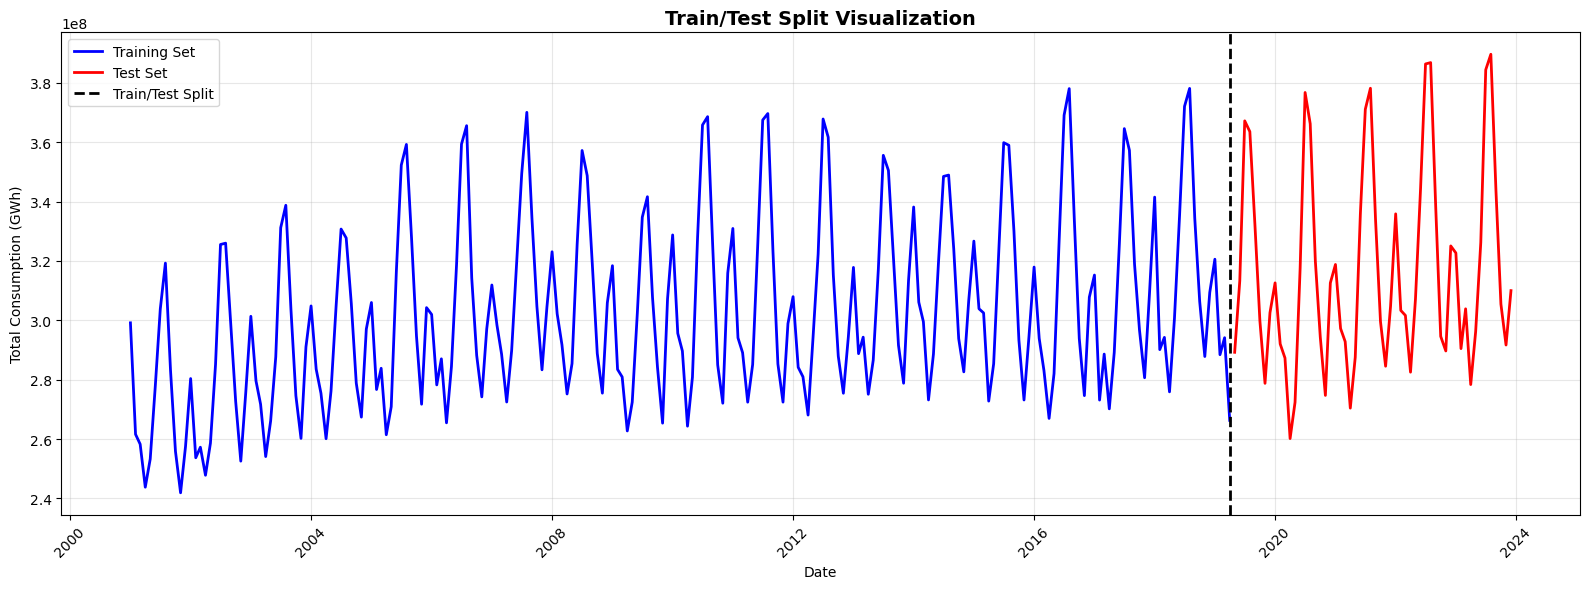

In [40]:
# Split: Use last 20% for test set (preserving time order)
feature_cols = [col for col in featured_df.columns if col != 'Total_Consumption_GWh']

X = featured_df[feature_cols]
y = featured_df['Total_Consumption_GWh']

# Split with test_size=0.2 and shuffle=False to preserve time order
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    shuffle=False,  # Critical: preserve temporal order for time series
    random_state=42
)

# Create train_df and test_df for visualization (preserving index)
train_df = featured_df.iloc[:len(X_train)].copy()
test_df = featured_df.iloc[len(X_train):].copy()

print(f"Training set: {train_df.index.min()} to {train_df.index.max()} ({len(train_df)} months)")
print(f"Test set: {test_df.index.min()} to {test_df.index.max()} ({len(test_df)} months)")

print(f"\nNumber of features: {len(feature_cols)}")

# Visualize the split
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(train_df.index, train_df['Total_Consumption_GWh'], 
        label='Training Set', color='blue', linewidth=2)
ax.plot(test_df.index, test_df['Total_Consumption_GWh'], 
        label='Test Set', color='red', linewidth=2)
ax.axvline(train_df.index[-1], color='black', linestyle='--', 
           linewidth=2, label='Train/Test Split')
ax.set_title('Train/Test Split Visualization', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Total Consumption (GWh)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Baseline Models


=== Baseline 1: Naive Persistence ===
RMSE: 29815465.76 GWh
MAE: 25548705.86 GWh

=== Baseline 2: Linear Regression (year, month, trend) ===
RMSE: 24678163.41 GWh
MAE: 21737957.16 GWh

Coefficients:
  year: 440101.5679
  month: -5166959.4846
  month_sin: -40059727.7085
  month_cos: -7651908.2500
  time_index: 114259.3306


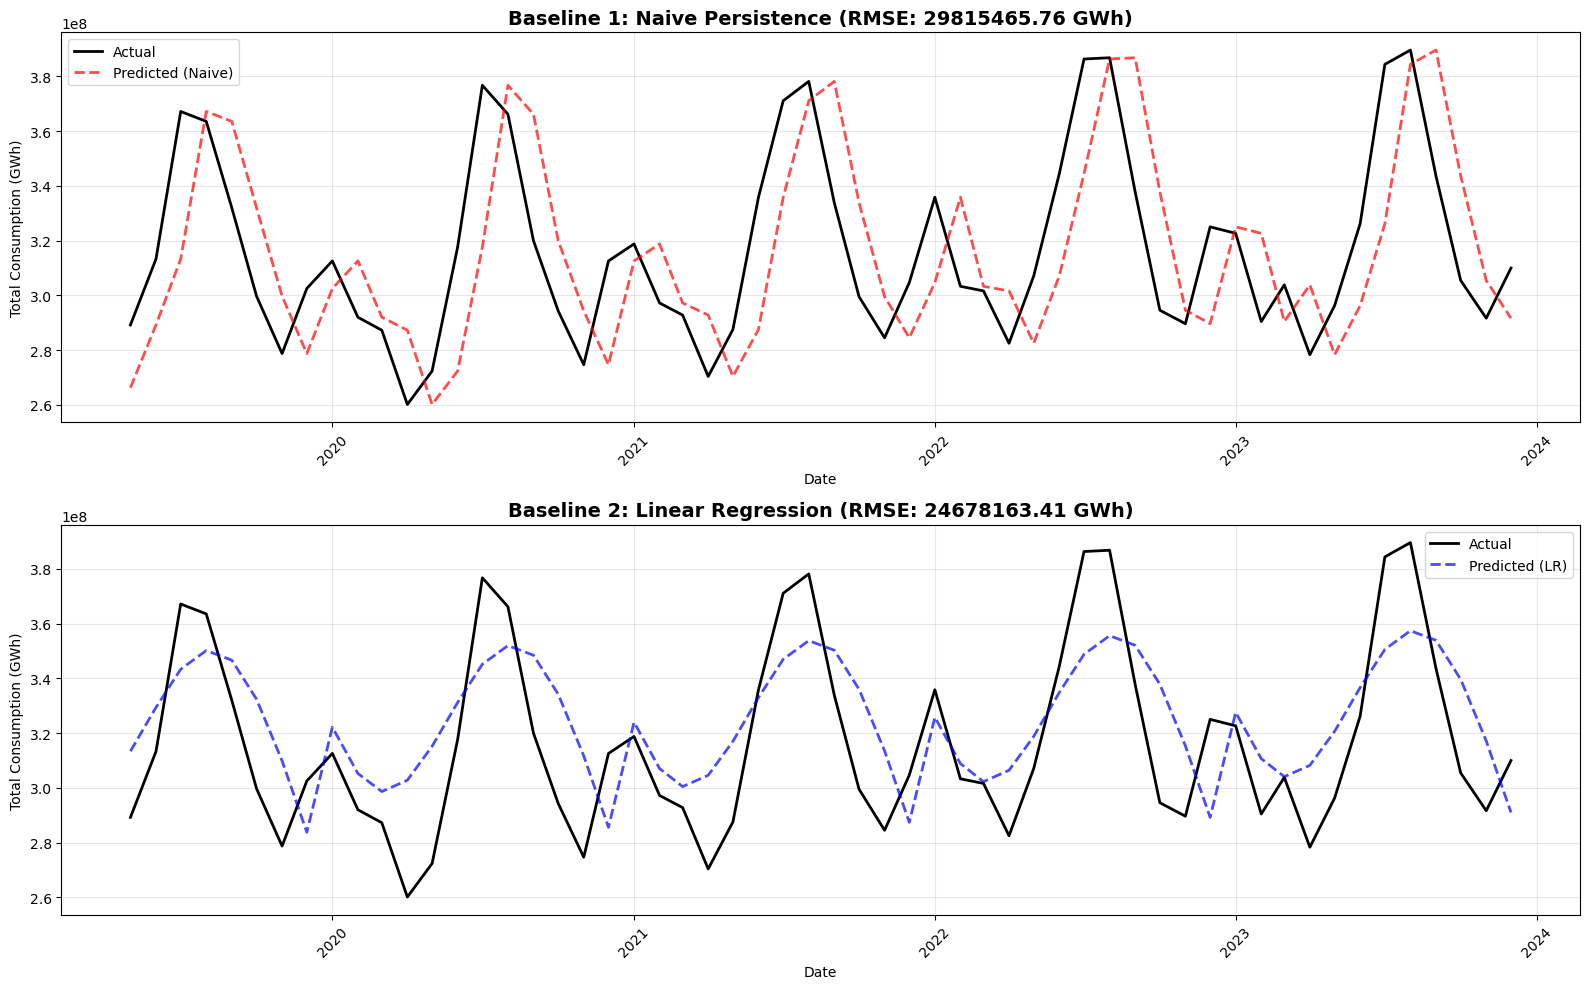

In [41]:
# Baseline 1: Naive Persistence (y_t = y_{t-1})
y_pred_naive = test_df['lag_1'].values
rmse_naive = np.sqrt(mean_squared_error(y_test, y_pred_naive))
mae_naive = mean_absolute_error(y_test, y_pred_naive)

print("=== Baseline 1: Naive Persistence ===")
print(f"RMSE: {rmse_naive:.2f} GWh")
print(f"MAE: {mae_naive:.2f} GWh")

# Baseline 2: Linear Regression with year and month
baseline_features = ['year', 'month', 'month_sin', 'month_cos', 'time_index']
X_train_baseline = train_df[baseline_features]
X_test_baseline = test_df[baseline_features]

lr_baseline = LinearRegression()
lr_baseline.fit(X_train_baseline, y_train)
y_pred_lr = lr_baseline.predict(X_test_baseline)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)

print("\n=== Baseline 2: Linear Regression (year, month, trend) ===")
print(f"RMSE: {rmse_lr:.2f} GWh")
print(f"MAE: {mae_lr:.2f} GWh")
print(f"\nCoefficients:")
for feat, coef in zip(baseline_features, lr_baseline.coef_):
    print(f"  {feat}: {coef:.4f}")

# Store baseline results
baseline_results = {
    'Naive Persistence': {'RMSE': rmse_naive, 'MAE': mae_naive},
    'Linear Regression': {'RMSE': rmse_lr, 'MAE': mae_lr}
}

# Visualize baseline predictions
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Naive persistence
axes[0].plot(test_df.index, y_test.values, label='Actual', linewidth=2, color='black')
axes[0].plot(test_df.index, y_pred_naive, label='Predicted (Naive)', 
             linewidth=2, linestyle='--', color='red', alpha=0.7)
axes[0].set_title(f'Baseline 1: Naive Persistence (RMSE: {rmse_naive:.2f} GWh)', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Total Consumption (GWh)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Linear regression
axes[1].plot(test_df.index, y_test.values, label='Actual', linewidth=2, color='black')
axes[1].plot(test_df.index, y_pred_lr, label='Predicted (LR)', 
             linewidth=2, linestyle='--', color='blue', alpha=0.7)
axes[1].set_title(f'Baseline 2: Linear Regression (RMSE: {rmse_lr:.2f} GWh)', 
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Total Consumption (GWh)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## Feature Selection with Time-Series Cross-Validation


### Unified Sequential Feature Selection (SFS & SBS) Across Models
We extend the single-model experiment to a reusable pipeline so each forecasting model (classical and neural) gets its own best feature set before final training.

In [42]:
# Utility estimators, helpers, and shared configuration for SFS/SBS runs

torch.manual_seed(42)


def _ensure_frame(X, columns=None):
    """Convert numpy arrays to DataFrames so feature names stay consistent."""
    if isinstance(X, pd.DataFrame):
        return X.copy()
    arr = np.asarray(X)
    col_names = columns if columns is not None else [f"feat_{i}" for i in range(arr.shape[1])]
    return pd.DataFrame(arr, columns=col_names)


class NaivePersistenceRegressor(BaseEstimator, RegressorMixin):
    """Sklearn-compatible estimator that mimics lag-1 persistence."""

    def __init__(self, preferred_feature='lag_1'):
        self.preferred_feature = preferred_feature

    def fit(self, X, y):
        X_df = _ensure_frame(X)
        self.columns_ = list(X_df.columns)
        if self.preferred_feature in self.columns_:
            self.selected_feature_ = self.preferred_feature
        else:
            y_series = pd.Series(np.asarray(y), index=X_df.index)
            corrs = X_df.apply(lambda col: col.corr(y_series)).fillna(0).abs()
            self.selected_feature_ = corrs.idxmax()
        return self

    def predict(self, X):
        X_df = _ensure_frame(X, getattr(self, 'columns_', None))
        return X_df[self.selected_feature_].values

    def score(self, X, y):
        preds = self.predict(X)
        return -mean_squared_error(y, preds)


class _SeqHead(nn.Module):
    """Small sequential head that can behave like LSTM/GRU/TFT."""

    def __init__(self, input_dim, hidden_dim, num_layers, dropout, cell_type):
        super().__init__()
        self.cell_type = cell_type.lower()
        if self.cell_type in {"lstm", "gru"}:
            rnn_cls = nn.LSTM if self.cell_type == "lstm" else nn.GRU
            self.core = rnn_cls(
                input_dim,
                hidden_dim,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout if num_layers > 1 else 0.0,
            )
            out_dim = hidden_dim
            self.proj = None
        else:  # lightweight transformer encoder to emulate TFT behaviour
            d_model = max(4, input_dim)
            self.proj = nn.Linear(input_dim, d_model)
            encoder_layer = nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=1,
                batch_first=True,
                dropout=dropout,
                activation="gelu",
                norm_first=True,
            )
            self.core = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
            out_dim = d_model
        self.head = nn.Sequential(
            nn.LayerNorm(out_dim),
            nn.Linear(out_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, x):
        if self.cell_type == "tft":
            x = self.proj(x)
            encoded = self.core(x)
            last = encoded[:, -1, :]
        else:
            out, _ = self.core(x)
            last = out[:, -1, :]
        return self.head(last).squeeze(-1)


class TorchSeqRegressor(BaseEstimator, RegressorMixin):
    """Minimal PyTorch regressor that plugs into sklearn workflows."""

    def __init__(
        self,
        cell_type="lstm",
        hidden_dim=64,
        num_layers=1,
        dropout=0.2,
        epochs=15,
        batch_size=32,
        lr=1e-3,
        device="auto",
        verbose=False,
    ):
        self.cell_type = cell_type
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.device = device
        self.verbose = verbose

    def _resolve_device(self):
        if self.device == "auto":
            return "cuda" if torch.cuda.is_available() else "cpu"
        return self.device

    def fit(self, X, y):
        X_arr = np.asarray(X, dtype=np.float32)
        if X_arr.ndim == 2:
            X_arr = np.expand_dims(X_arr, axis=1)
        y_arr = np.asarray(y, dtype=np.float32)
        dataset = TensorDataset(torch.from_numpy(X_arr), torch.from_numpy(y_arr))
        if len(dataset) == 0:
            raise ValueError("Training data is empty")
        loader = DataLoader(
            dataset,
            batch_size=min(self.batch_size, len(dataset)),
            shuffle=True,
            drop_last=False,
        )
        self._device = self._resolve_device()
        self.model_ = _SeqHead(
            input_dim=X_arr.shape[-1],
            hidden_dim=self.hidden_dim,
            num_layers=self.num_layers,
            dropout=self.dropout,
            cell_type=self.cell_type,
        ).to(self._device)
        optimizer = torch.optim.Adam(self.model_.parameters(), lr=self.lr)
        loss_fn = nn.MSELoss()
        self.loss_history_ = []
        for epoch in range(self.epochs):
            epoch_loss = 0.0
            for xb, yb in loader:
                xb = xb.to(self._device)
                yb = yb.to(self._device)
                optimizer.zero_grad()
                preds = self.model_(xb)
                loss = loss_fn(preds, yb)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item() * len(xb)
            epoch_loss /= len(dataset)
            self.loss_history_.append(epoch_loss)
            if self.verbose:
                print(f"Epoch {epoch + 1}/{self.epochs} | loss={epoch_loss:.4f}")
        self.model_.eval()
        return self

    def predict(self, X):
        if not hasattr(self, "model_"):
            raise RuntimeError("Model has not been fit yet")
        X_arr = np.asarray(X, dtype=np.float32)
        if X_arr.ndim == 2:
            X_arr = np.expand_dims(X_arr, axis=1)
        tensor = torch.from_numpy(X_arr).to(self._device)
        with torch.no_grad():
            preds = self.model_(tensor).cpu().numpy()
        return preds

    def score(self, X, y):
        preds = self.predict(X)
        return -mean_squared_error(y, preds)


In [43]:
# Run SFS/SBS for every model in scope

tscv = TimeSeriesSplit(n_splits=5)
total_features = len(X_train.columns)
feature_cap = min(12, total_features)

model_configs = {
    "Naive Persistence": {
        "estimator": NaivePersistenceRegressor(preferred_feature="lag_1"),
        "forward_k": 1,
        "backward_k": 1,
        "n_jobs": 1,
    },
    "Linear Regression": {
        "estimator": LinearRegression(),
        "forward_k": 'auto',
        "backward_k": 'auto',
        "n_jobs": -1,
    },
    "XGBoost": {
        "estimator": XGBRegressor(
            n_estimators=250,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            random_state=42,
            n_jobs=-1,
            verbosity=0,
        ),
        "forward_k": 'auto',
        "backward_k": 'auto',
        "n_jobs": -1,
    },
    "LSTM": {
        "estimator": TorchSeqRegressor(
            cell_type="lstm",
            hidden_dim=72,
            num_layers=1,
            dropout=0.2,
            epochs=12,
            batch_size=32,
            lr=2e-3,
        ),
        "forward_k": feature_cap,
        "backward_k": feature_cap,
        "n_jobs": 1,
    },
    "GRU": {
        "estimator": TorchSeqRegressor(
            cell_type="gru",
            hidden_dim=72,
            num_layers=1,
            dropout=0.2,
            epochs=12,
            batch_size=32,
            lr=2e-3,
        ),
        "forward_k": feature_cap,
        "backward_k": feature_cap,
        "n_jobs": 1,
    },
    "TFT": {
        "estimator": TorchSeqRegressor(
            cell_type="tft",
            hidden_dim=96,
            num_layers=2,
            dropout=0.1,
            epochs=14,
            batch_size=32,
            lr=1.5e-3,
        ),
        "forward_k": feature_cap,
        "backward_k": feature_cap,
        "n_jobs": 1,
    },
}

selected_features = {}


def _run_selector(model_name, estimator, direction, n_features, n_jobs):
    if isinstance(n_features, int):
        target_feats = max(1, min(n_features, total_features))
    else:
        target_feats = n_features
    selector = SequentialFeatureSelector(
        estimator=clone(estimator),
        n_features_to_select=target_feats,
        direction=direction,
        scoring='neg_mean_squared_error',
        cv=tscv,
        n_jobs=n_jobs,
    )
    selector.fit(X_train, y_train)
    feats = X_train.columns[selector.get_support()].tolist()
    print(f"{model_name:<20} | {direction.upper()} picked {len(feats)} features")
    print(feats)
    return feats


for model_name, cfg in model_configs.items():
    print("\n" + "=" * 80)
    print(f"Running feature selection for: {model_name}")
    print("=" * 80)
    model_results = {}
    model_results['SFS'] = _run_selector(
        model_name,
        cfg['estimator'],
        direction='forward',
        n_features=cfg.get('forward_k', 'auto'),
        n_jobs=cfg.get('n_jobs', 1),
    )
    model_results['SBS'] = _run_selector(
        model_name,
        cfg['estimator'],
        direction='backward',
        n_features=cfg.get('backward_k', 'auto'),
        n_jobs=cfg.get('n_jobs', 1),
    )
    selected_features[model_name] = model_results

print("\nCompleted SFS/SBS for all configured models.")



Running feature selection for: Naive Persistence
Naive Persistence    | FORWARD picked 1 features
['lag_12']
Naive Persistence    | BACKWARD picked 1 features
['lag_12']

Running feature selection for: Linear Regression
Linear Regression    | FORWARD picked 13 features
['month', 'lag_1', 'lag_8', 'lag_11', 'lag_12', 'roll_mean_3', 'roll_std_3', 'roll_std_6', 'roll_std_12', 'yoy_change', 'yoy_pct_change', 'mom_change', 'mom_pct_change']
Linear Regression    | BACKWARD picked 14 features
['year', 'month_cos', 'lag_1', 'lag_3', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_12', 'roll_mean_3', 'roll_std_3', 'roll_std_12', 'yoy_change']

Running feature selection for: XGBoost
XGBoost              | FORWARD picked 13 features
['month', 'month_sin', 'month_cos', 'lag_1', 'lag_4', 'lag_8', 'lag_10', 'lag_11', 'lag_12', 'roll_std_6', 'yoy_change', 'yoy_pct_change', 'mom_change']
XGBoost              | BACKWARD picked 14 features
['month', 'month_sin', 'month_cos', 'lag_1', 'lag_4', 'lag_5'

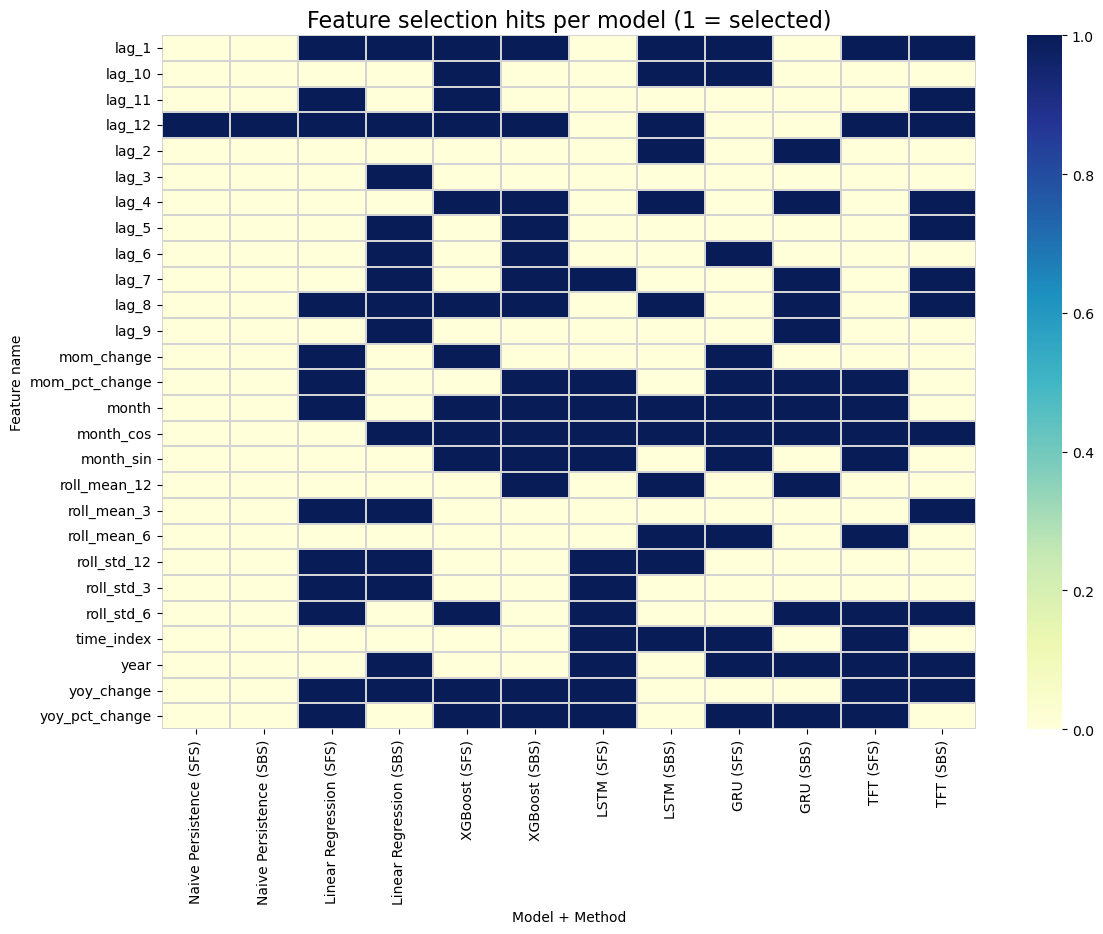

,Model,SFS #,SBS #,SFS Features,SBS Features
4,GRU,12,12,"year, month, month_sin, month_cos, time_index,...","year, month, month_cos, lag_2, lag_4, lag_7, l..."
3,LSTM,12,12,"year, month, month_sin, month_cos, time_index,...","month, month_cos, time_index, lag_1, lag_2, la..."
1,Linear Regression,13,14,"month, lag_1, lag_8, lag_11, lag_12, roll_mean...","year, month_cos, lag_1, lag_3, lag_5, lag_6, l..."
0,Naive Persistence,1,1,lag_12,lag_12
5,TFT,12,12,"year, month, month_sin, month_cos, time_index,...","year, month_cos, lag_1, lag_4, lag_5, lag_7, l..."
2,XGBoost,13,14,"month, month_sin, month_cos, lag_1, lag_4, lag...","month, month_sin, month_cos, lag_1, lag_4, lag..."


In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

all_features = sorted(feature_cols)
feature_hits = {}
for model_name, methods in selected_features.items():
    for method, feats in methods.items():
        col_name = f"{model_name} ({method})"
        feature_hits[col_name] = [1 if feat in feats else 0 for feat in all_features]

feature_matrix = pd.DataFrame(feature_hits, index=all_features)
plt.figure(figsize=(12, max(6, len(all_features) * 0.35)))
sns.heatmap(
    feature_matrix,
    cmap="YlGnBu",
    cbar=True,
    linewidths=0.2,
    linecolor="lightgray",
)
plt.title("Feature selection hits per model (1 = selected)", fontsize=16)
plt.xlabel("Model + Method")
plt.ylabel("Feature name")
plt.tight_layout()
plt.show()

feature_summary = []
for model_name, methods in selected_features.items():
    feature_summary.append({
        "Model": model_name,
        "SFS #": len(methods['SFS']),
        "SBS #": len(methods['SBS']),
        "SFS Features": ', '.join(methods['SFS']),
        "SBS Features": ', '.join(methods['SBS']),
    })

feature_summary_df = pd.DataFrame(feature_summary).sort_values("Model")
feature_summary_df


## Model Training and Evaluation


In [45]:
# Train each model on the best-performing feature subset (SFS vs SBS)

def train_and_evaluate(estimator, feature_list, variant_label):
    if not feature_list:
        return None
    est = clone(estimator)
    est.fit(X_train[feature_list], y_train)
    preds = est.predict(X_test[feature_list])
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    return {
        "Variant": variant_label,
        "Feature Set": feature_list,
        "Preds": preds,
        "RMSE": rmse,
        "MAE": mae,
    }

model_performance = []
model_predictions = {}

for model_name, cfg in model_configs.items():
    variant_results = []
    for variant in ["SFS", "SBS"]:
        result = train_and_evaluate(cfg['estimator'], selected_features[model_name].get(variant, []), variant)
        if result:
            variant_results.append(result)
    if not variant_results:
        continue
    best_variant = min(variant_results, key=lambda res: res['RMSE'])
    model_predictions[model_name] = best_variant
    model_performance.append({
        "Model": model_name,
        "Variant": best_variant['Variant'],
        "Feature Count": len(best_variant['Feature Set']),
        "Features": best_variant['Feature Set'],
        "RMSE": best_variant['RMSE'],
        "MAE": best_variant['MAE'],
    })
    print(f"{model_name:<20} | {best_variant['Variant']} -> RMSE {best_variant['RMSE']:.3f} | MAE {best_variant['MAE']:.3f}")

model_performance


Naive Persistence    | SFS -> RMSE 10525820.973 | MAE 9159493.615
Linear Regression    | SFS -> RMSE 0.000 | MAE 0.000
XGBoost              | SFS -> RMSE 6258656.316 | MAE 4243093.303
LSTM                 | SBS -> RMSE 318705062.220 | MAE 316904392.519
GRU                  | SBS -> RMSE 318705004.250 | MAE 316904334.115
TFT                  | SFS -> RMSE 318705166.664 | MAE 316904496.986


[{'Model': 'Naive Persistence',
  'Variant': 'SFS',
  'Feature Count': 1,
  'Features': ['lag_12'],
  'RMSE': np.float64(10525820.972863311),
  'MAE': 9159493.614642853},
 {'Model': 'Linear Regression',
  'Variant': 'SFS',
  'Feature Count': 13,
  'Features': ['month',
   'lag_1',
   'lag_8',
   'lag_11',
   'lag_12',
   'roll_mean_3',
   'roll_std_3',
   'roll_std_6',
   'roll_std_12',
   'yoy_change',
   'yoy_pct_change',
   'mom_change',
   'mom_pct_change'],
  'RMSE': np.float64(5.475036224983286e-08),
  'MAE': 4.204256193978446e-08},
 {'Model': 'XGBoost',
  'Variant': 'SFS',
  'Feature Count': 13,
  'Features': ['month',
   'month_sin',
   'month_cos',
   'lag_1',
   'lag_4',
   'lag_8',
   'lag_10',
   'lag_11',
   'lag_12',
   'roll_std_6',
   'yoy_change',
   'yoy_pct_change',
   'mom_change'],
  'RMSE': np.float64(6258656.315788085),
  'MAE': 4243093.303035712},
 {'Model': 'LSTM',
  'Variant': 'SBS',
  'Feature Count': 12,
  'Features': ['month',
   'month_cos',
   'time_index

## Model Visualization and Diagnostics


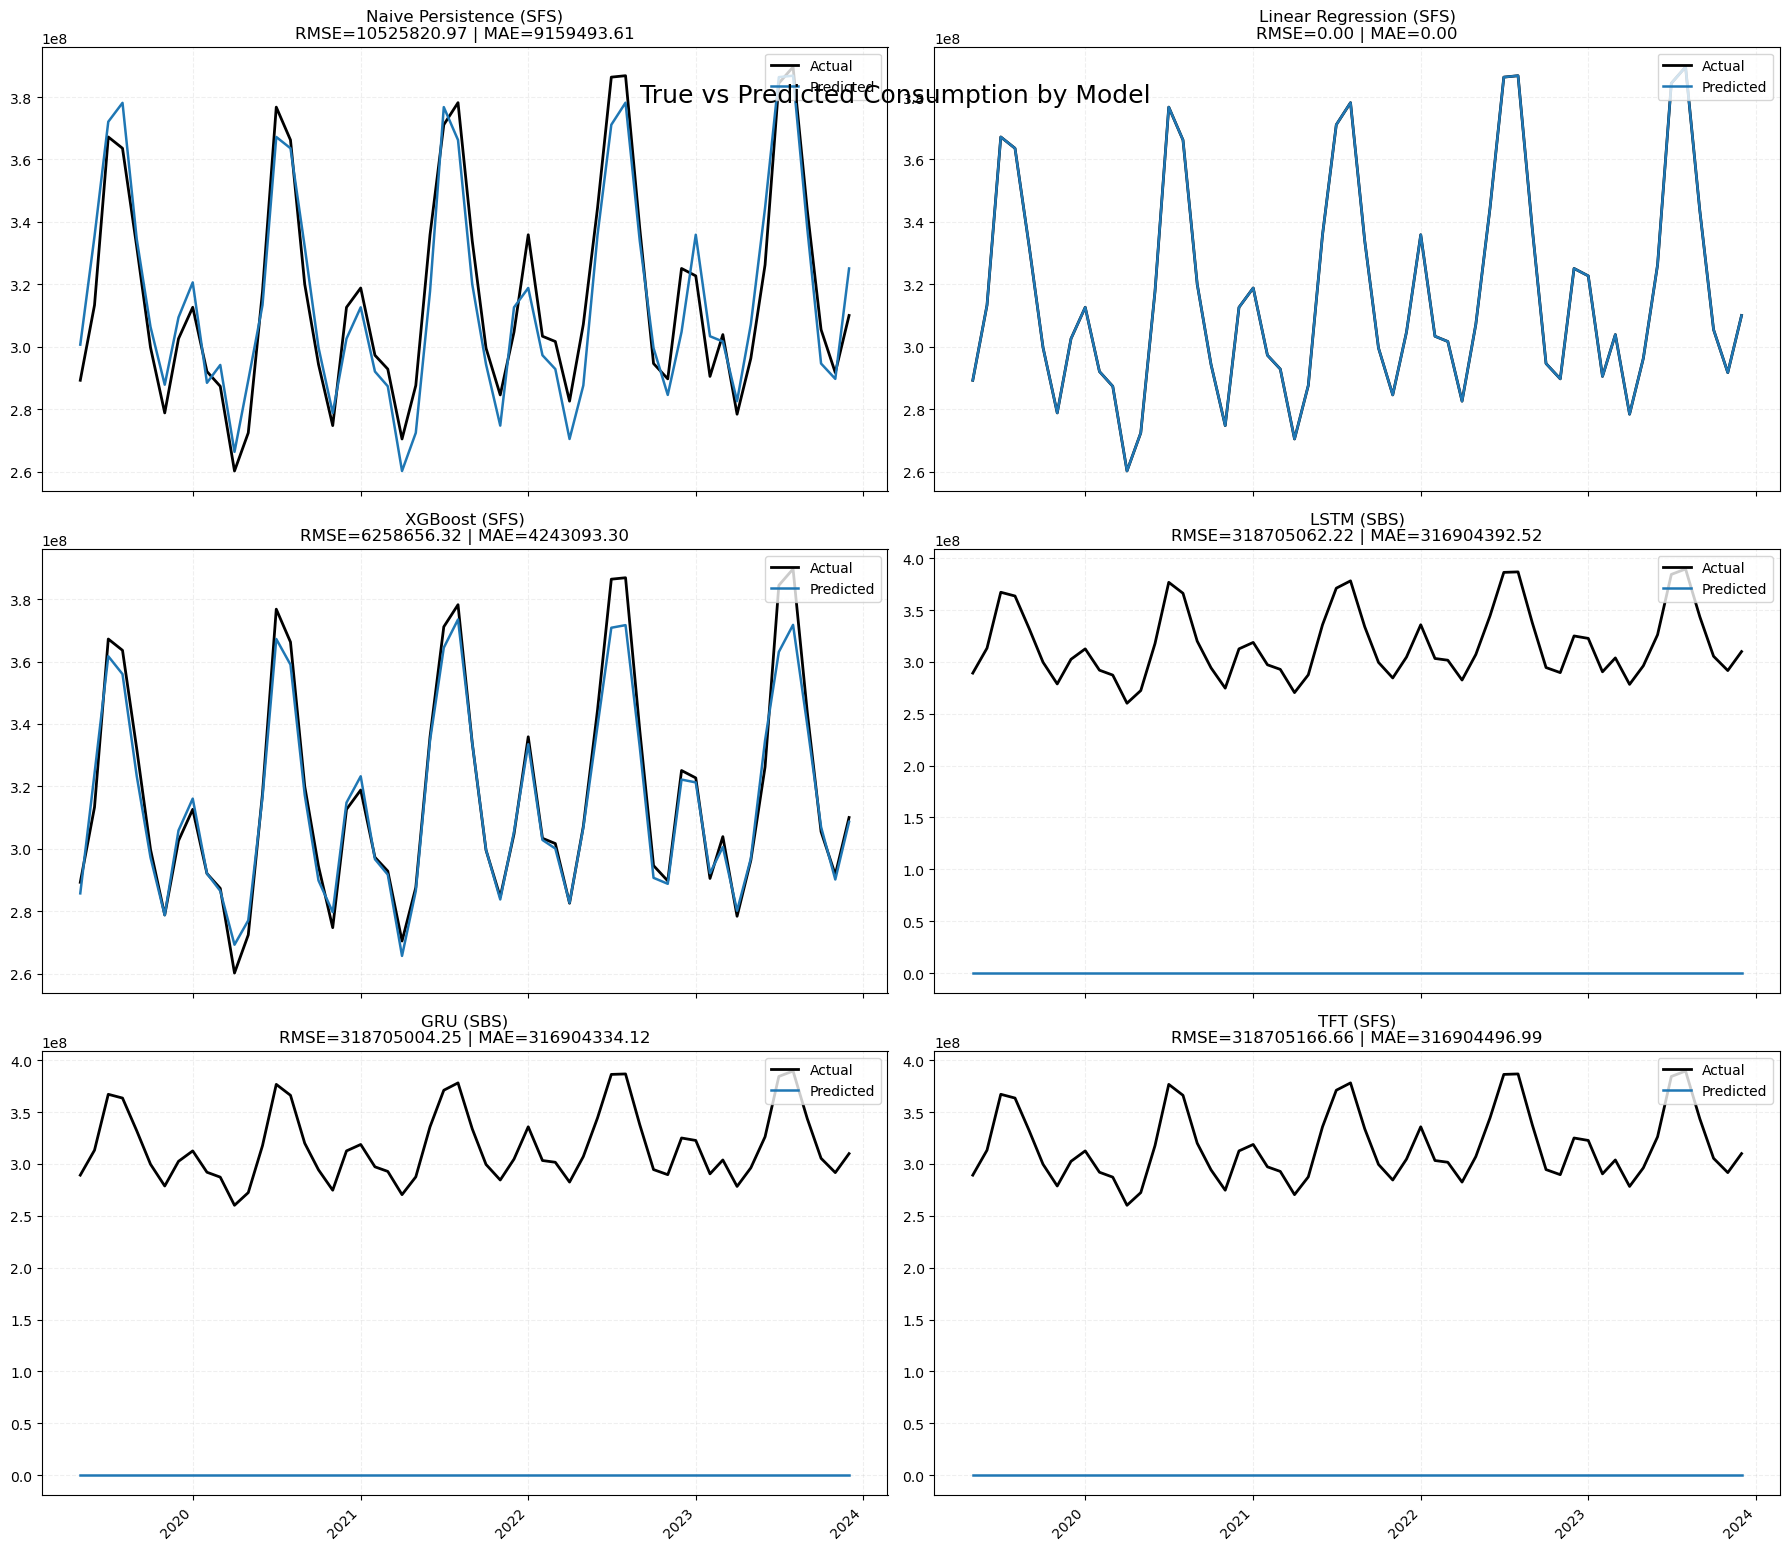

In [46]:
# Actual vs predicted series for every model (best variant)
fig, axes = plt.subplots(3, 2, figsize=(18, 16), sharex=True)
axes = axes.flatten()
time_index = test_df.index
actual_series = y_test.values

for ax, perf in zip(axes, model_performance):
    preds = model_predictions[perf['Model']]['Preds']
    ax.plot(time_index, actual_series, label='Actual', color='black', linewidth=2)
    ax.plot(time_index, preds, label='Predicted', color='tab:blue', linewidth=1.8)
    ax.set_title(f"{perf['Model']} ({perf['Variant']})\nRMSE={perf['RMSE']:.2f} | MAE={perf['MAE']:.2f}")
    ax.legend(loc='upper right')
    ax.grid(True, linestyle='--', alpha=0.2)

for ax in axes[len(model_performance):]:
    ax.axis('off')

fig.suptitle('True vs Predicted Consumption by Model', fontsize=18, y=0.92)
fig.autofmt_xdate(rotation=45)
plt.tight_layout()
plt.show()


In [47]:
# Aggregate metrics across all models
performance_df = (
    pd.DataFrame(model_performance)
      .sort_values("RMSE")
      .reset_index(drop=True)
)
performance_df


,Model,Variant,Feature Count,Features,RMSE,MAE
0,Linear Regression,SFS,13,"[month, lag_1, lag_8, lag_11, lag_12, roll_mea...",5.475036e-08,4.204256e-08
1,XGBoost,SFS,13,"[month, month_sin, month_cos, lag_1, lag_4, la...",6.258656e+06,4.243093e+06
2,Naive Persistence,SFS,1,[lag_12],1.052582e+07,9.159494e+06
3,GRU,SBS,12,"[year, month, month_cos, lag_2, lag_4, lag_7, ...",3.187050e+08,3.169043e+08
4,LSTM,SBS,12,"[month, month_cos, time_index, lag_1, lag_2, l...",3.187051e+08,3.169044e+08
5,TFT,SFS,12,"[year, month, month_sin, month_cos, time_index...",3.187052e+08,3.169045e+08


## Model Comparison Visualization


MODEL COMPARISON SUMMARY (Best Variant per Model)
 Rank             Model Variant         RMSE          MAE  Feature Count  Improvement over Naive (%)
    1 Linear Regression     SFS 5.475036e-08 4.204256e-08             13                  100.000000
    2           XGBoost     SFS 6.258656e+06 4.243093e+06             13                   79.008692
    3 Naive Persistence     SFS 1.052582e+07 9.159494e+06              1                   64.696775
    4               GRU     SBS 3.187050e+08 3.169043e+08             12                 -968.925124
    5              LSTM     SBS 3.187051e+08 3.169044e+08             12                 -968.925318
    6               TFT     SFS 3.187052e+08 3.169045e+08             12                 -968.925668


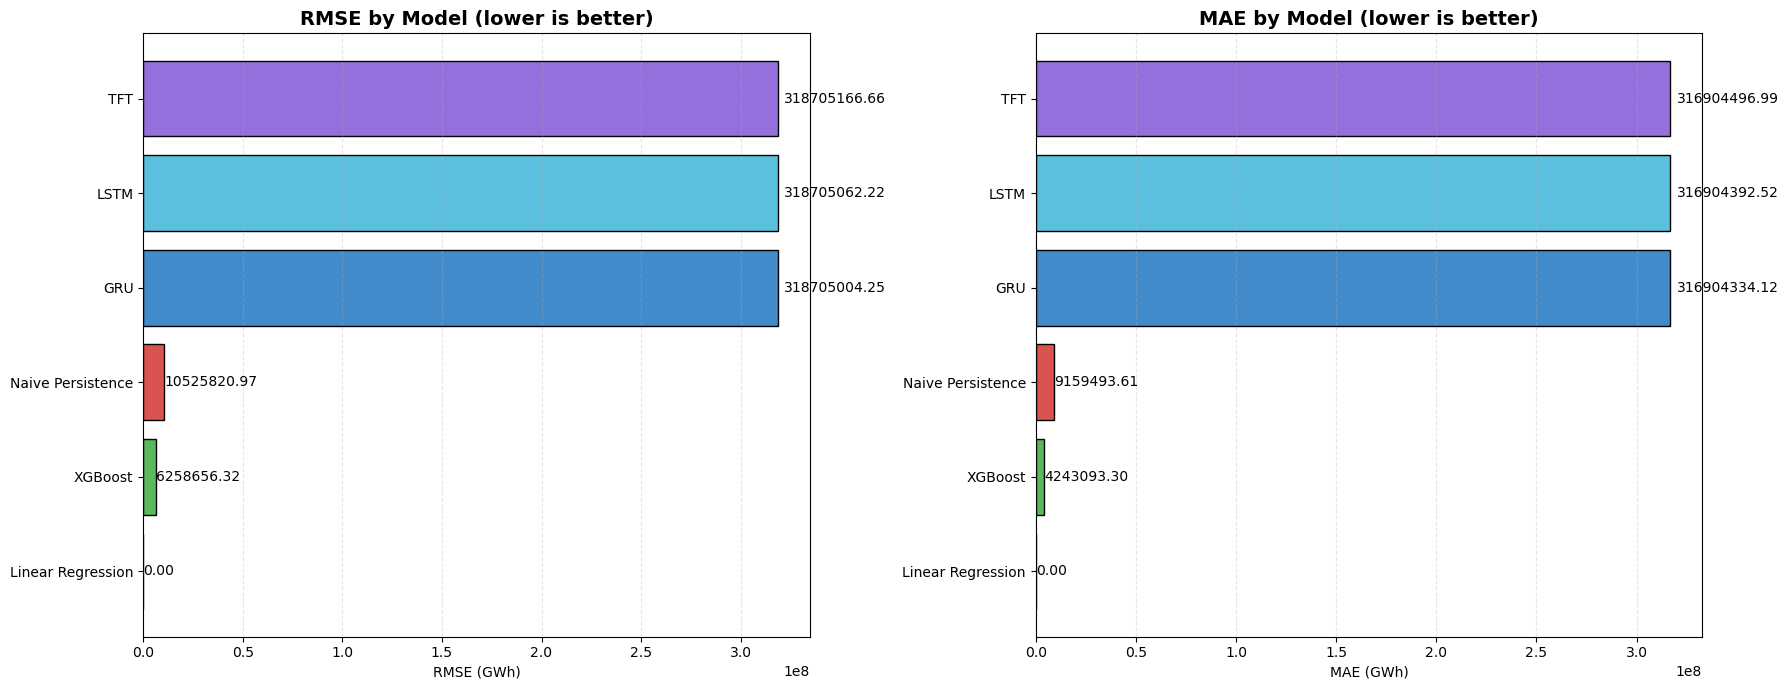

In [48]:
# Summary + visualization using the best variant per model
comparison_df = performance_df.copy()
comparison_df['Improvement over Naive (%)'] = (
    (rmse_naive - comparison_df['RMSE']) / rmse_naive * 100
)
comparison_df = comparison_df.sort_values('RMSE').reset_index(drop=True)
comparison_df['Rank'] = comparison_df.index + 1

print("\n" + "=" * 80)
print("MODEL COMPARISON SUMMARY (Best Variant per Model)")
print("=" * 80)
print(comparison_df[['Rank', 'Model', 'Variant', 'RMSE', 'MAE', 'Feature Count', 'Improvement over Naive (%)']].to_string(index=False))
print("=" * 80)

color_map = {
    'Naive Persistence': '#d9534f',
    'Linear Regression': '#f0ad4e',
    'XGBoost': '#5cb85c',
    'LSTM': '#5bc0de',
    'GRU': '#428bca',
    'TFT': '#9370db'
}

def _color_for_model(name):
    for key, val in color_map.items():
        if key in name:
            return val
    return '#5bc0de'

bar_colors = [_color_for_model(model) for model in comparison_df['Model']]

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
axes[0].barh(comparison_df['Model'], comparison_df['RMSE'], color=bar_colors, edgecolor='black')
axes[0].set_title('RMSE by Model (lower is better)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('RMSE (GWh)')
axes[0].grid(axis='x', linestyle='--', alpha=0.3)
for i, v in enumerate(comparison_df['RMSE']):
    axes[0].text(v * 1.01, i, f"{v:.2f}", va='center')

axes[1].barh(comparison_df['Model'], comparison_df['MAE'], color=bar_colors, edgecolor='black')
axes[1].set_title('MAE by Model (lower is better)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('MAE (GWh)')
axes[1].grid(axis='x', linestyle='--', alpha=0.3)
for i, v in enumerate(comparison_df['MAE']):
    axes[1].text(v * 1.01, i, f"{v:.2f}", va='center')

plt.tight_layout()
plt.show()
